# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [5]:
!pip install lightning wandb
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
--2025-01-20 17:52:30--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2025-01-20 17:52:30--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.1’



In [10]:
import wandb
from dotenv import load_dotenv
import os

load_dotenv()

True

In [12]:
# !wandb login
api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/idhibhatpankam/.netrc


True

In [13]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [14]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2025-01-20 17:56:09--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv’

mp_name_th_en.csv   100%[===================>] 316.80K  --.-KB/s    in 0.08s   

2025-01-20 17:56:09 (3.83 MB/s) - ‘mp_name_th_en.csv’ saved [324399/324399]



In [15]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [16]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [17]:
#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars)+1
output_vocab_size = len(output_chars)+2#+2 for special end of sentence token/PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max input length

There are 10887 lines and 65 unique characters in your input data.


In [18]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 19


In [20]:
sorted_chars = sorted(input_chars)
sorted_chars.insert(0, "<PAD>")
sorted_chars.insert(1, "</s>")

sorted_output_chars = sorted(output_chars)
sorted_output_chars.insert(0, "<PAD>")

input_stoi = { c:i for i, c in enumerate(sorted_chars) }
input_itos = { i:c for i, c in enumerate(sorted_chars)}
input_encode = lambda sentence: [input_stoi[c] for c in sentence]
input_decode = lambda encoding: "".join([input_itos[i] for i in encoding])

output_stoi = { c:i for i, c in enumerate(sorted_output_chars) }
output_itos = { i:c for i, c in enumerate(sorted_output_chars)}
output_encode = lambda sentence: [output_stoi[c] for c in sentence]
output_decode = lambda encoding: "".join([output_itos[i] for i in encoding])

print(input_encode(name_th[0]))
print(input_decode(input_encode(name_th[0])))

[59, 3, 35, 40, 50, 41, 65]
ไกรสีห์


In [21]:
print(input_stoi)
print(output_stoi)

{'<PAD>': 0, '</s>': 1, ' ': 2, 'ก': 3, 'ข': 4, 'ค': 5, 'ฆ': 6, 'ง': 7, 'จ': 8, 'ฉ': 9, 'ช': 10, 'ซ': 11, 'ฌ': 12, 'ญ': 13, 'ฎ': 14, 'ฏ': 15, 'ฐ': 16, 'ฑ': 17, 'ฒ': 18, 'ณ': 19, 'ด': 20, 'ต': 21, 'ถ': 22, 'ท': 23, 'ธ': 24, 'น': 25, 'บ': 26, 'ป': 27, 'ผ': 28, 'ฝ': 29, 'พ': 30, 'ฟ': 31, 'ภ': 32, 'ม': 33, 'ย': 34, 'ร': 35, 'ล': 36, 'ว': 37, 'ศ': 38, 'ษ': 39, 'ส': 40, 'ห': 41, 'ฬ': 42, 'อ': 43, 'ฮ': 44, 'ะ': 45, 'ั': 46, 'า': 47, 'ำ': 48, 'ิ': 49, 'ี': 50, 'ึ': 51, 'ื': 52, 'ุ': 53, 'ู': 54, 'เ': 55, 'แ': 56, 'โ': 57, 'ใ': 58, 'ไ': 59, '็': 60, '่': 61, '้': 62, '๊': 63, '๋': 64, '์': 65}
{'<PAD>': 0, '-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'w': 21, 'y': 22}


In [47]:
X = []
for line in name_th:
    X.append(torch.tensor(input_encode(line)))
Y = []
for line in name_en:
    Y.append(torch.tensor(output_encode(line)))

X = nn.utils.rnn.pad_sequence(X, batch_first=True)
Y = nn.utils.rnn.pad_sequence(Y, batch_first=True)

In [51]:
X.shape, Y.shape

(torch.Size([10887, 20]), torch.Size([10887, 19]))

In [52]:
X[0], Y[0]

(tensor([59,  3, 35, 40, 50, 41, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0]),
 tensor([11, 17,  2, 10, 18, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0]))

In [49]:
Ty = len(max(Y, key=len))
Ty

19

In [31]:
from torch.utils.data import Dataset, DataLoader
from torch.types import Tensor

In [61]:
class NameDataset(Dataset):
  def __init__(self, X, y):
    self.encoded = X.long()
    self.label = y.long()

  def __getitem__(self, idx):
    return {"x": self.encoded[idx], "y": self.label[idx]}

  def __len__(self):
    return len(self.encoded)

In [62]:
class NameDataModule(L.LightningDataModule):

  def __init__(self, train_data, y, batch_size, num_workers=0):
      super().__init__()
      self.train_data = train_data
      self.y = y
      self.batch_size = batch_size
      self.num_workers = num_workers


  def setup(self, stage: str):
    pass

  def collate_fn(self, batch):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_stoi)) for b in batch])
    return {"x": one_hot_x.float(), "y": torch.stack([b["y"] for b in batch])}

  def train_dataloader(self):
    train_dataset = NameDataset(self.train_data, self.y)
    train_loader = DataLoader(train_dataset,
                              batch_size=self.batch_size,
                              shuffle=True,
                              collate_fn=self.collate_fn,
                              num_workers=self.num_workers)
    return train_loader


# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [124]:
def one_step_attention(h: Tensor, s_prev: Tensor, linear_1: nn.Linear, linear_2: nn.Linear):
    # (enc) h.shape = batch, seq_len, hidden_dim
    # (dec) s_prev.shape = batch, hidden_dim
    # print(f"h.shape: {h.shape}, s_prev.shape: {s_prev.shape}")

    # Split into Key-Value
    hidden_dim = h.shape[-1]
    key_dim, value_dim = hidden_dim // 2, hidden_dim // 2
    key, value = torch.split(h, [key_dim, value_dim], dim=-1)
    # key: (batch, seq_len, key_dim), value: (batch, seq_len, value_dim)

    seq_len = key.shape[1]
    # unsqueeze: (batch, hidden_dim) -> (batch, 1, hidden_dim)
    # repeat: (batch, 1, hidden_dim) -> (batch, seq_len, hidden_dim)
    s_prev = s_prev.unsqueeze(1).repeat(1, seq_len, 1)

    # do concat with s_prev.
    concat = torch.cat([key, s_prev], dim=-1) # (batch, seq_len, key_dim + hidden_dim)
    # print(f"concat.shape: {concat.shape}")

    # hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    # hint2: s_prev.unsqueeze() could also be useful

    # Attention function
    # use layer(s) from your model to calculate attention_scores and then softmax
    # calculate a context vector
    e = F.tanh(linear_1(concat))
    # print(f"e.shape: {e.shape}")
    energies = F.relu(linear_2(e))
    # print(f"e.shape: {e.shape}, energies.shape: {energies.shape}")
    attention_scores = F.softmax(energies, dim=1)
    context = torch.sum(attention_scores * value.repeat(1,1,2), dim=1)
    # print(f"context: {context.shape}, attention_scores.shape: {attention_scores.shape}, value.shape: {value.shape}")

    return context, attention_scores

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [125]:
output_vocab = output_stoi
class AttentionModel(L.LightningModule):
    def __init__(self, learning_rate, criterion):

        super().__init__()
        self.n_h = 32 # hidden dimensions for encoder
        self.n_s = 64 # hidden dimensions for decoder
        self.learning_rate = learning_rate
        self.criterion = criterion

        #encoder can be any RNN of your choice
        bidirection = True
        self.num_directions = 2 if bidirection else 1
        self.lstm = nn.LSTM(len(input_stoi), self.n_h, bidirectional=bidirection, batch_first=True)

        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(self.n_s, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(output_vocab))
        
        #attention
        self.fc1 = nn.Linear(self.n_h*self.num_directions*3//2, self.n_h)
        self.fc2 = nn.Linear(self.n_h, 1)

    def forward(self, src, return_attention=False): 
        # use return_attention only when you want to get the attention scores for visualizing
        # pass the input to the encoder
        lstm_out, _ = self.lstm(src)
        # print(f"lstm_out.shape: {lstm_out.shape}, fc1.weight.shape: {self.fc1.weight.shape}, fc2.weight.shape: {self.fc2.weight.shape}")

        # Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        # These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        # Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], Ty, len(output_vocab))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] # to store the score for each step
        for t in range(Ty):
            # Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(lstm_out, decoder_s, self.fc1, self.fc2)

            # Feed the context vector to the decoder.
            # print(f"decoder_s.shape: {decoder_s.shape}, decoder_c.shape: {decoder_c.shape}, lstm_cell.shape: {self.decoder_lstm_cell.weight_ih.shape}")
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))

            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)

            # Put the predicted output into the list for this timestep
            prediction[:, t] = out

            attention_scores.append(attention_score)

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch['x']
        target = batch['y']
        prediction,_ = self(src)
        prediction = prediction.reshape(-1, len(output_vocab))
        target = target.reshape(-1)
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        src = batch['x']
        with torch.no_grad():
          prediction, attention_scores = self(src, return_attention=True)
          prediction = F.softmax(prediction, dim=-1)
          prediction = torch.argmax(prediction, dim=-1)
          for pred in prediction:
            print("".join(output_decode(pred.cpu().numpy())))
            # print("".join(output_vocab.lookup_tokens(pred.cpu().numpy())))
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [126]:
data_module = NameDataModule(X, Y, batch_size=16)

In [127]:
mock_data = NameDataset(X, Y)
criterion = nn.CrossEntropyLoss()
lr = 0.01
mock_model = AttentionModel(lr, criterion)
mock_batch = next(iter(data_module.train_dataloader()))
mock_model.training_step(mock_batch, 0)

tensor(3.1722, grad_fn=<NllLossBackward0>)

In [128]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
model = AttentionModel(lr, criterion)

In [129]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="hw3.1_attention")

In [130]:
trainer = L.Trainer(
    max_epochs=100,
    logger=wandb_logger
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [131]:
trainer.fit(model, data_module)


  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0      | train
1 | lstm              | LSTM             | 25.6 K | train
2 | decoder_lstm_cell | LSTMCell         | 33.3 K | train
3 | output_layer      | Linear           | 1.5 K  | train
4 | fc1               | Linear           | 3.1 K  | train
5 | fc2               | Linear           | 33     | train
---------------------------------------------------------------
63.5 K    Trainable params
0         Non-trainable params
63.5 K    Total params
0.254     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 10:   3%|▎         | 19/681 [00:01<00:57, 11.42it/s, v_num=7l44]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [133]:
EXAMPLES = ['ประยุทธ','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ']
predict_data = []
for line in EXAMPLES:
    line = [l for l in line] #change from string to list
    predict_data.append(torch.tensor(input_encode(line)))

print(len(predict_data))
def collate_fn(batch):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_stoi)) for b in batch])
    return {"x": one_hot_x.float()}

predict_data = nn.utils.rnn.pad_sequence(predict_data, batch_first = True)
predict_dataset = NameDataset(predict_data, torch.tensor([torch.tensor(0)]*len(predict_data)))
predict_loader = DataLoader(predict_dataset,
                          batch_size = 1,
                          shuffle = False,
                          collate_fn = collate_fn,
                          num_workers = 0)

7


In [134]:
model.eval()

AttentionModel(
  (criterion): CrossEntropyLoss()
  (lstm): LSTM(66, 32, batch_first=True, bidirectional=True)
  (decoder_lstm_cell): LSTMCell(64, 64)
  (output_layer): Linear(in_features=64, out_features=23, bias=True)
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [135]:
output = trainer.predict(model, predict_loader)

prediction, attention_scores = zip(*output)


/Users/idhibhatpankam/Code/courses/NLP-SYS/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
prediction, attention_scores = zip(*output)


In [ ]:
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text,rotation=30)
ax.set_xticklabels(xlabels,rotation=60)
plt.show()

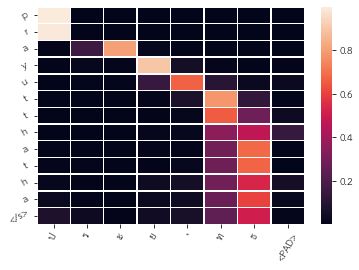

In [ ]:
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text,rotation=30)
ax.set_xticklabels(xlabels,rotation=60)
plt.show()